In [69]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [66]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [8]:
data_dict = joblib.load('/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_40/data.joblib')


Starting Cluster Optimization...
  k=2: DB=1.280 (Lower=Better), CH=19292.0 (Higher=Better)
  k=3: DB=1.051 (Lower=Better), CH=17074.6 (Higher=Better)
  k=4: DB=0.931 (Lower=Better), CH=21327.7 (Higher=Better)
  k=5: DB=1.134 (Lower=Better), CH=19853.6 (Higher=Better)
  k=6: DB=1.124 (Lower=Better), CH=19483.0 (Higher=Better)
  k=7: DB=1.166 (Lower=Better), CH=18335.6 (Higher=Better)
  k=8: DB=1.172 (Lower=Better), CH=17438.1 (Higher=Better)
  k=9: DB=1.103 (Lower=Better), CH=17099.5 (Higher=Better)
  k=10: DB=1.050 (Lower=Better), CH=16767.9 (Higher=Better)
  k=11: DB=1.055 (Lower=Better), CH=16450.4 (Higher=Better)
  k=12: DB=1.038 (Lower=Better), CH=16066.5 (Higher=Better)
  k=13: DB=1.034 (Lower=Better), CH=15798.7 (Higher=Better)
  k=14: DB=0.936 (Lower=Better), CH=16066.3 (Higher=Better)
  k=15: DB=0.963 (Lower=Better), CH=15925.5 (Higher=Better)


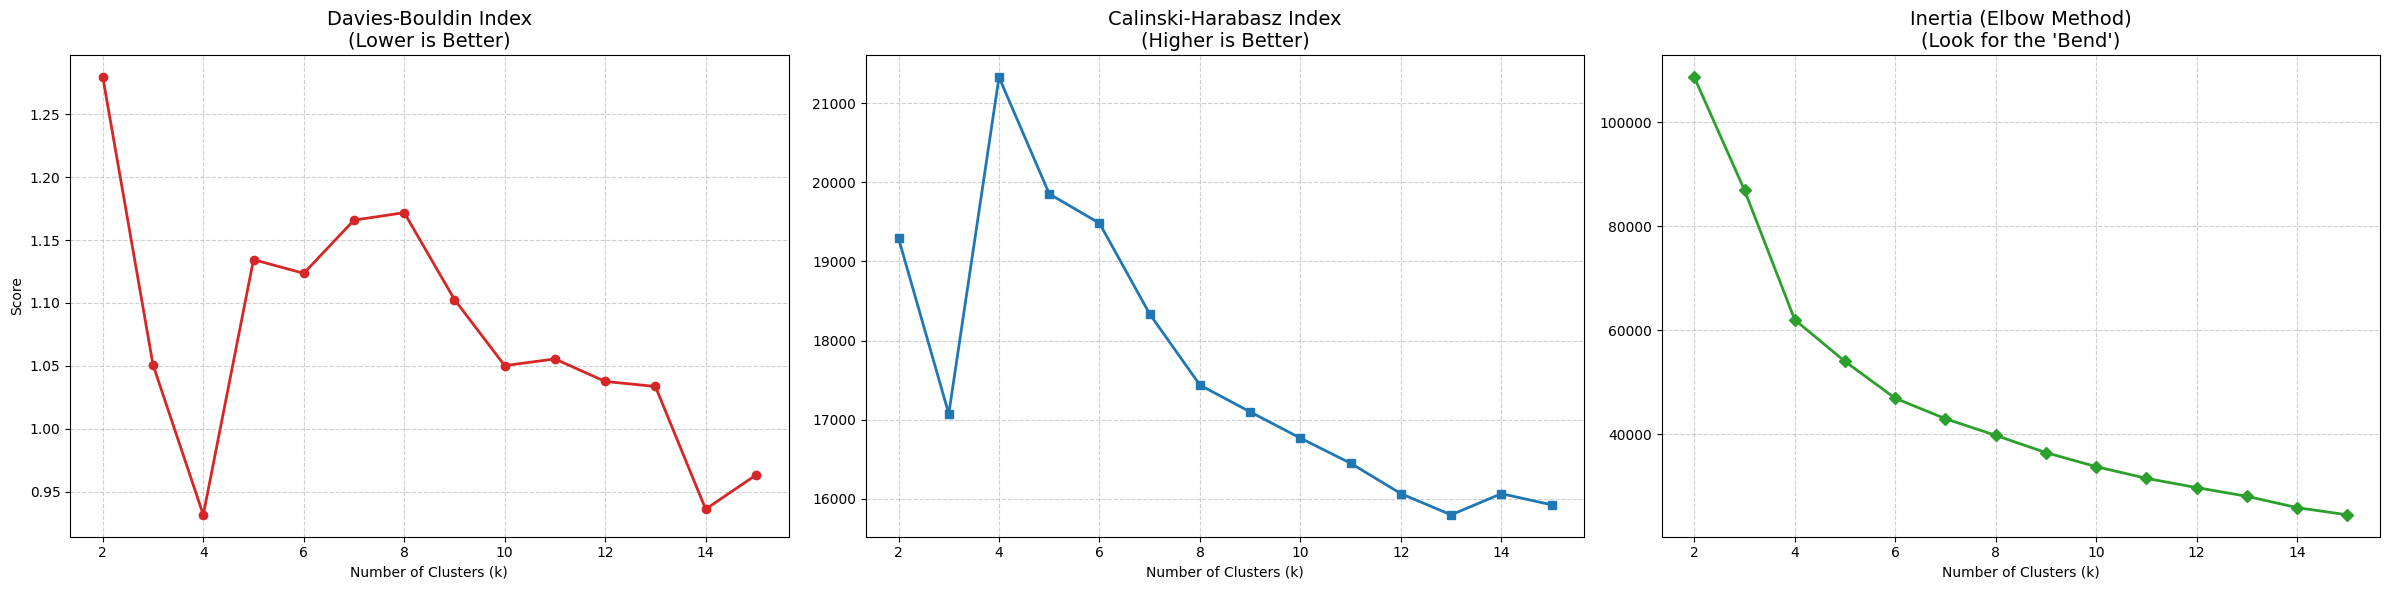

In [74]:
#determining cluster number

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# --- 1. PREPARE DATA (Weighted Features) ---
# Ensure these variables exist from your previous cells:
# data_dict, clean_mask, Px_list, Py_list

# Config
SPATIAL_WEIGHT = 1.0  # Keep consistent with your preferred visualization
MAG_THRESHOLD = 0

# Extract
raw_Y = data_dict['com_grid'][:, 0]
raw_X = data_dict['com_grid'][:, 1]
raw_U = data_dict['Px_list']
raw_V = data_dict['Py_list']

# Filter
magnitudes = np.sqrt(raw_U**2 + raw_V**2)
mask = (magnitudes >= MAG_THRESHOLD)

Y = raw_Y[mask]
X = raw_X[mask]
U = raw_U[mask]
V = raw_V[mask]

# Standardize & Weight
scaler_spatial = StandardScaler()
spatial_feats = scaler_spatial.fit_transform(np.column_stack([X, Y]))

scaler_physics = StandardScaler()
physics_feats = scaler_physics.fit_transform(np.column_stack([U, V]))

# The feature set we are testing
weighted_features = np.hstack([spatial_feats * SPATIAL_WEIGHT, physics_feats])

# --- 2. THE LOOP (Test k=2 to k=15) ---
k_values = range(2, 16)
db_scores = []
ch_scores = []
inertia_scores = [] # "Elbow Method" score

print("Starting Cluster Optimization...")
for k in k_values:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels = kmeans.fit_predict(weighted_features)

    # Calculate Metrics
    db = davies_bouldin_score(weighted_features, labels)
    ch = calinski_harabasz_score(weighted_features, labels)

    db_scores.append(db)
    ch_scores.append(ch)
    inertia_scores.append(kmeans.inertia_)

    print(f"  k={k}: DB={db:.3f} (Lower=Better), CH={ch:.1f} (Higher=Better)")

# --- 3. PLOTTING ---
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot 1: Davies-Bouldin (Minimize)
axes[0].plot(k_values, db_scores, marker='o', color='tab:red', linewidth=2)
axes[0].set_title("Davies-Bouldin Index\n(Lower is Better)", fontsize=14)
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Score")
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Calinski-Harabasz (Maximize)
axes[1].plot(k_values, ch_scores, marker='s', color='tab:blue', linewidth=2)
axes[1].set_title("Calinski-Harabasz Index\n(Higher is Better)", fontsize=14)
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Inertia (The Elbow)
axes[2].plot(k_values, inertia_scores, marker='D', color='tab:green', linewidth=2)
axes[2].set_title("Inertia (Elbow Method)\n(Look for the 'Bend')", fontsize=14)
axes[2].set_xlabel("Number of Clusters (k)")
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# --- 1. CONFIGURATION ---
# Adjust this to balance Physics vs. Location
# 0.5 = Physics dominates (long, snaky clusters allowed)
# 2.0 = Location dominates (clusters forced to be round blobs)
SPATIAL_WEIGHT = 1.0
N_CLUSTERS = 4
ARROW_SCALE = 0.1  # Same as your previous quiver plot
MAG_THRESHOLD = 0 # Filter noise

# --- 2. PREPARE DATA ---
# Extract raw lists
raw_Y = data_dict['com_grid'][:, 0] # Rows
raw_X = data_dict['com_grid'][:, 1] # Cols
raw_U = data_dict['Px_list']
raw_V = data_dict['Py_list']

# Create Clean Mask (High Magnitude only)
magnitudes = np.sqrt(raw_U**2 + raw_V**2)
clean_mask = magnitudes >= MAG_THRESHOLD

# Apply Mask
Y = raw_Y[clean_mask]
X = raw_X[clean_mask]
U = raw_U[clean_mask]
V = raw_V[clean_mask]

# --- 3. CLUSTERING (THE DREAM) ---
# Standardize features so X/Y (0-4000) don't overpower U/V (-1 to 1)
scaler_spatial = StandardScaler()
spatial_feats = scaler_spatial.fit_transform(np.column_stack([X, Y]))

scaler_physics = StandardScaler()
physics_feats = scaler_physics.fit_transform(np.column_stack([U, V]))

# Combine with weight
weighted_features = np.hstack([spatial_feats * SPATIAL_WEIGHT, physics_feats])

# Run K-Means
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(weighted_features)

# --- 4. PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# PLOT A: Quiver (The Physics)
# Calculate angles for coloring
angles = np.arctan2(V, U)
norm = Normalize(vmin=-np.pi, vmax=np.pi)
colors_quiver = cm.hsv(norm(angles))

# Plot
axes[0].quiver(X, Y, U, V, color=colors_quiver,
               scale=ARROW_SCALE, angles='xy', scale_units='xy', width=0.002)
axes[0].set_title("Original Quiver Plot (Colored by Angle)", fontsize=18)

# PLOT B: Superpixel Clusters (The Segmentation)
scatter = axes[1].scatter(X, Y, c=labels, cmap='tab10', vmin=0, vmax=9, s=15, alpha=0.9)
axes[1].set_title(f"Superpixel Segmentation\n(Spatial Weight={SPATIAL_WEIGHT}, k={N_CLUSTERS})", fontsize=18)

# Formatting for both
for ax in axes:
    ax.set_aspect('equal')
    ax.invert_yaxis() # Match image coordinates (0,0 at top-left)
    ax.set_xlim(350, 4000)
    ax.set_ylim(4100, 350)
    ax.set_xlabel("X (Pixels)")
    ax.set_ylabel("Y (Pixels)")

plt.tight_layout()
# --- ADD LEGEND ---
from matplotlib.lines import Line2D

# Get the colormap
cmap = plt.get_cmap('tab10')

# Create manual legend elements that match the fixed scatter colors
legend_elements = []
for i in range(N_CLUSTERS):
    # We normalized 0-9 in the scatter, so we must pick color i from that same range
    # Note: tab10(i) works directly for integers 0-9
    color = cmap(i)
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
               markerfacecolor=color, markersize=10)
    )

axes[1].legend(handles=legend_elements, title="Clusters", loc='upper right')
plt.show()


#save labels
print(labels.shape)
print(data_dict['X'].shape)
np.save('/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_40/clustered_labels.npy', labels)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([17568,  3602, 11200,  7822]))

# Testing Cluster Labels as Ground Truth for Model Training

In [84]:
# Supervised Learning- imports
#

!pip install git+https://github.com/pycaret/pycaret.git@master
import pycaret
from pycaret.classification import *

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to /tmp/pip-req-build-gwi948kn
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /tmp/pip-req-build-gwi948kn
  Resolved https://github.com/pycaret/pycaret.git to commit 58ec3c282d58e94727f9d5b77b49f241e9103ab3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pmdarima to determine which version is compatible with other 

RuntimeError: empty_like method already has a different docstring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import pandas as pd
import pycaret
from pycaret.classification import *
data_dict = joblib.load('/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_40/data.joblib')

y = np.load('/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_40/clustered_labels.npy')
X = data_dict['X']
X_flat = X.reshape(X.shape[0], -1)

print(X.shape)
print(y.shape)


ModuleNotFoundError: No module named 'pycaret'

In [6]:
import numpy as np
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm  # Progress bar for Jupyter/Colab
import time

# Flatten X for Scikit-Learn (samples, features)
X_flat = X.reshape(X.shape[0], -1)
# Flatten y to 1D array
y_flat = y.ravel()

print(f"Data Loaded. X Shape: {X_flat.shape}, y Shape: {y_flat.shape}")

# --- 2. Setup Model & CV ---
# n_jobs=-1 uses all processors. Change to n_jobs=1 if you want to save RAM.

# 5 Folds
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics
accuracies = []
precisions = []
recalls = []
f1s = []

print(f"\nStarting Cross-Validation with {n_splits} folds...")

# --- 3. Run Loop with Progress Updates ---
# tqdm gives you a nice visual progress bar
for i, (train_index, val_index) in tqdm(enumerate(cv.split(X_flat, y_flat)), total=n_splits, desc="CV Progress"):

    start_time = time.time()
    fold_num = i + 1
    print(f"\n--- Fold {fold_num}/{n_splits} ---")

    # Split Data
    X_train, X_val = X_flat[train_index], X_flat[val_index]
    y_train, y_val = y_flat[train_index], y_flat[val_index]
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

    # Train
    print(f"   Training Random Forest on {len(X_train)} samples...")
    rf_model.fit(X_train, y_train)

    # Predict
    print("   Predicting on validation set...")
    y_pred = rf_model.predict(X_val)

    # Calculate Metrics (average='macro' for multiclass 1-4)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

    # Store
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(classification_report(y_val, y_pred))

    elapsed = time.time() - start_time
    print(f"   Done in {elapsed:.1f}s. Accuracy: {acc:.4f} | F1: {f1:.4f}")

# --- 4. Final Report ---
print("\n" + "="*40)
print("FINAL CROSS-VALIDATION RESULTS")
print("="*40)
print(f"Average Accuracy:  {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall:    {np.mean(recalls):.4f}")
print(f"Average F1 Score:  {np.mean(f1s):.4f}")
print("="*40)

Data Loaded. X Shape: (40192, 1600), y Shape: (40192,)

Starting Cross-Validation with 5 folds...


CV Progress:   0%|          | 0/5 [00:00<?, ?it/s]


--- Fold 1/5 ---
   Training Random Forest on 32153 samples...
   Predicting on validation set...
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      3514
           1       0.48      0.14      0.22       720
           2       0.81      0.74      0.78      2240
           3       0.78      0.65      0.71      1565

    accuracy                           0.75      8039
   macro avg       0.70      0.62      0.63      8039
weighted avg       0.74      0.75      0.73      8039

   Done in 225.4s. Accuracy: 0.7547 | F1: 0.6321

--- Fold 2/5 ---
   Training Random Forest on 32153 samples...
   Predicting on validation set...
              precision    recall  f1-score   support

           0       0.74      0.94      0.82      3514
           1       0.52      0.14      0.22       720
           2       0.82      0.77      0.79      2240
           3       0.79      0.65      0.71      1565

    accuracy                           0.76   

# Making all cluster labels

Here I loop through all the window sizes for 0% Serenium and make cluster labels. For this we know to use 4 clusters.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

for window in [80, 40, 20, 10, 5]:
  data_dict = joblib.load(f'/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_{window}/data.joblib')
  print(window)
  # --- 1. CONFIGURATION ---
  print("data prep...")
  # Adjust this to balance Physics vs. Location
  # 0.5 = Physics dominates (long, snaky clusters allowed)
  # 2.0 = Location dominates (clusters forced to be round blobs)
  SPATIAL_WEIGHT = 1.0
  N_CLUSTERS = 4
  ARROW_SCALE = 0.1  # Same as your previous quiver plot
  MAG_THRESHOLD = 0 # Filter noise

  # --- 2. PREPARE DATA ---
  # Extract raw lists
  raw_Y = data_dict['com_grid'][:, 0] # Rows
  raw_X = data_dict['com_grid'][:, 1] # Cols
  raw_U = data_dict['Px_list']
  raw_V = data_dict['Py_list']

  # Create Clean Mask (High Magnitude only)
  magnitudes = np.sqrt(raw_U**2 + raw_V**2)
  clean_mask = magnitudes >= MAG_THRESHOLD

  # Apply Mask
  Y = raw_Y[clean_mask]
  X = raw_X[clean_mask]
  U = raw_U[clean_mask]
  V = raw_V[clean_mask]

  # --- 3. CLUSTERING (THE DREAM) ---
  # Standardize features so X/Y (0-4000) don't overpower U/V (-1 to 1)
  scaler_spatial = StandardScaler()
  spatial_feats = scaler_spatial.fit_transform(np.column_stack([X, Y]))

  scaler_physics = StandardScaler()
  physics_feats = scaler_physics.fit_transform(np.column_stack([U, V]))

  # Combine with weight
  weighted_features = np.hstack([spatial_feats * SPATIAL_WEIGHT, physics_feats])

  # Run K-Means
  print("clustering...")
  kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
  labels = kmeans.fit_predict(weighted_features)

  # --- 4. PLOTTING ---
  print("plotting...")
  fig, axes = plt.subplots(1, 2, figsize=(24, 12))

  # PLOT A: Quiver (The Physics)
  # Calculate angles for coloring
  angles = np.arctan2(V, U)
  norm = Normalize(vmin=-np.pi, vmax=np.pi)
  colors_quiver = cm.hsv(norm(angles))

  # Plot
  axes[0].quiver(X, Y, U, V, color=colors_quiver,
                scale=ARROW_SCALE, angles='xy', scale_units='xy', width=0.002)
  axes[0].set_title("Original Quiver Plot (Colored by Angle)", fontsize=18)

  # PLOT B: Superpixel Clusters (The Segmentation)
  scatter = axes[1].scatter(X, Y, c=labels, cmap='tab10', vmin=0, vmax=9, s=15, alpha=0.9)
  axes[1].set_title(f"Superpixel Segmentation\n(Spatial Weight={SPATIAL_WEIGHT}, k={N_CLUSTERS})", fontsize=18)

  # Formatting for both
  for ax in axes:
      ax.set_aspect('equal')
      ax.invert_yaxis() # Match image coordinates (0,0 at top-left)
      ax.set_xlim(350, 4000)
      ax.set_ylim(4100, 350)
      ax.set_xlabel("X (Pixels)")
      ax.set_ylabel("Y (Pixels)")

  plt.tight_layout()

  # Get the colormap
  cmap = plt.get_cmap('tab10')

  # Create manual legend elements that match the fixed scatter colors
  legend_elements = []
  for i in range(N_CLUSTERS):
      # We normalized 0-9 in the scatter, so we must pick color i from that same range
      # Note: tab10(i) works directly for integers 0-9
      color = cmap(i)
      legend_elements.append(
          Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                markerfacecolor=color, markersize=10)
      )

  axes[1].legend(handles=legend_elements, title="Clusters", loc='upper right')

  print(np.unique(labels, return_counts=True))

  print("saving...")

  #save fig to file for future looking
  plt.savefig(f'/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_{window}/clustered_comparison.png')
  plt.show()

  #save labels
  print(labels.shape)
  print(data_dict['X'].shape)
  np.save(f'/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_{window}/clustered_labels.npy', labels)


Output hidden; open in https://colab.research.google.com to view.

Now I do random forest on all of the window sizes, printing classification report

In [ ]:
import numpy as np
import joblib
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.notebook import tqdm
import time

# List of window sizes to iterate through
window_sizes = [80, 40, 20, 10, 5]

for window in window_sizes:
    # --- 1. Define Paths ---
    base_path = f'/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_{window}'
    data_path = f'{base_path}/data.joblib'
    labels_path = f'{base_path}/clustered_labels.npy'
    results_path = f'{base_path}/classification_results.txt'

    print(f"\n{'#'*60}")
    print(f"BEGINNING PROCESSING FOR WINDOW SIZE {window}")
    print(f"{'#'*60}")

    # Check if files exist
    if not os.path.exists(data_path) or not os.path.exists(labels_path):
        print(f"Skipping Window {window}: Data file not found at {base_path}")
        continue

    # Load Data
    data_dict = joblib.load(data_path)
    y = np.load(labels_path)
    X = data_dict['X']

    # Flatten Data
    X_flat = X.reshape(X.shape[0], -1)
    y_flat = y.ravel()

    print(f"Data Loaded. X Shape: {X_flat.shape}, y Shape: {y_flat.shape}")

    # --- 2. Setup Model & CV ---
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store metrics
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    # We will store the classification report from the last fold to display as a sample
    last_fold_report = ""

    print(f"Starting Cross-Validation with {n_splits} folds...")

    # --- 3. Run Loop ---
    for i, (train_index, val_index) in tqdm(enumerate(cv.split(X_flat, y_flat)), total=n_splits, desc=f"CV Win-{window}"):

        fold_num = i + 1

        # Split Data
        X_train, X_val = X_flat[train_index], X_flat[val_index]
        y_train, y_val = y_flat[train_index], y_flat[val_index]

        # Define Model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

        # Train
        rf_model.fit(X_train, y_train)

        # Predict
        y_pred = rf_model.predict(X_val)

        # Calculate Metrics
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

        # Store metrics
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

        # Update last report
        last_fold_report = classification_report(y_val, y_pred)

        print(last_fold_report)
        elapsed = time.time() - start_time
        print(f"   Done in {elapsed:.1f}s. Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # --- 4. Prepare Results String ---
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_prec = np.mean(precisions)
    avg_rec = np.mean(recalls)
    avg_f1 = np.mean(f1s)

    # Create a formatted string for both Console and File
    results_text = (
        f"\n=================================================\n"
        f"CLASSIFICATION RESULTS - WINDOW SIZE {window}\n"
        f"=================================================\n"
        f"Model: RandomForestClassifier(n_estimators=100, class_weight='balanced')\n"
        f"Validation: {n_splits}-Fold Stratified CV\n\n"
        f"--- Overall Performance ---\n"
        f"Average Accuracy:  {avg_acc:.4f} (+/- {std_acc:.4f})\n"
        f"Average Precision: {avg_prec:.4f}\n"
        f"Average Recall:    {avg_rec:.4f}\n"
        f"Average F1 Score:  {avg_f1:.4f}\n\n"
        f"--- Detailed Report (from final fold) ---\n"
        f"{last_fold_report}\n"
    )

    # --- 5. PRINT TO CONSOLE ---
    print(results_text)

    # --- 6. SAVE TO FILE ---
    with open(results_path, "w") as f:
        f.write(results_text)

    print(f"✅ Saved results copy to: {results_path}\n\n")


############################################################
BEGINNING PROCESSING FOR WINDOW SIZE 80
############################################################
Data Loaded. X Shape: (9832, 6400), y Shape: (9832,)
Starting Cross-Validation with 5 folds...


CV Win-80:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       757
           1       0.79      0.67      0.72       364
           2       0.83      0.82      0.83       541
           3       0.77      0.55      0.64       305

    accuracy                           0.78      1967
   macro avg       0.78      0.73      0.75      1967
weighted avg       0.78      0.78      0.77      1967

   Done in 2128.8s. Accuracy: 0.7783 | F1: 0.7510
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       756
           1       0.83      0.67      0.74       364
           2       0.80      0.84      0.82       541
           3       0.77      0.50      0.61       306

    accuracy                           0.77      1967
   macro avg       0.78      0.72      0.74      1967
weighted avg       0.78      0.77      0.77      1967

   Done in 2215.6s. Accuracy: 0.7733 | F1: 0.7429
              precision    rec

CV Win-40:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.73      0.93      0.82      3514
           1       0.48      0.14      0.22       720
           2       0.81      0.74      0.78      2240
           3       0.78      0.65      0.71      1565

    accuracy                           0.75      8039
   macro avg       0.70      0.62      0.63      8039
weighted avg       0.74      0.75      0.73      8039

   Done in 2684.0s. Accuracy: 0.7547 | F1: 0.6321
              precision    recall  f1-score   support

           0       0.74      0.94      0.82      3514
           1       0.52      0.14      0.22       720
           2       0.82      0.77      0.79      2240
           3       0.79      0.65      0.71      1565

    accuracy                           0.76      8039
   macro avg       0.72      0.62      0.64      8039
weighted avg       0.75      0.76      0.74      8039

   Done in 2892.8s. Accuracy: 0.7624 | F1: 0.6382
              precision    rec

CV Win-20:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.66      0.84      0.74     11512
           1       0.79      0.79      0.79     11767
           2       0.35      0.00      0.01      1204
           3       0.55      0.43      0.48      8014

    accuracy                           0.69     32497
   macro avg       0.59      0.52      0.51     32497
weighted avg       0.67      0.69      0.67     32497

   Done in 4056.0s. Accuracy: 0.6884 | F1: 0.5058
              precision    recall  f1-score   support

           0       0.66      0.83      0.74     11513
           1       0.79      0.79      0.79     11767
           2       0.38      0.01      0.01      1204
           3       0.56      0.44      0.49      8013

    accuracy                           0.69     32497
   macro avg       0.60      0.52      0.51     32497
weighted avg       0.67      0.69      0.67     32497

   Done in 4592.4s. Accuracy: 0.6871 | F1: 0.5072
              precision    rec

CV Win-10:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     60082
           1       0.75      0.77      0.76     61173
           2       0.00      0.00      0.00      1209
           3       0.36      0.00      0.00      8215

    accuracy                           0.72    130679
   macro avg       0.45      0.39      0.38    130679
weighted avg       0.70      0.72      0.70    130679

   Done in 7902.7s. Accuracy: 0.7248 | F1: 0.3763
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     60082
           1       0.75      0.77      0.76     61173
           2       0.50      0.00      0.00      1209
           3       0.45      0.00      0.00      8215

    accuracy                           0.73    130679
   macro avg       0.60      0.39      0.38    130679
weighted avg       0.71      0.73      0.70    130679

   Done in 9573.9s. Accuracy: 0.7259 | F1: 0.3777
              precision    rec

CV Win-5:   0%|          | 0/5 [00:00<?, ?it/s]

below i check for duplicates; we can see in output that there aren't any duplicates, so data isn't bleeding from train to test

In [2]:
import numpy as np
import joblib
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.notebook import tqdm
import time

# List of window sizes to iterate through
window_sizes = [80, 40, 20, 10, 5]

for window in window_sizes:
    # --- 1. Define Paths ---
    base_path = f'/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_{window}'
    data_path = f'{base_path}/data.joblib'
    labels_path = f'{base_path}/clustered_labels.npy'
    results_path = f'{base_path}/classification_results_no_duplicates.txt'

    print(f"\n{'#'*60}")
    print(f"BEGINNING PROCESSING FOR WINDOW SIZE {window}")
    print(f"{'#'*60}")

    # Check if files exist
    if not os.path.exists(data_path) or not os.path.exists(labels_path):
        print(f"Skipping Window {window}: Data file not found at {base_path}")
        continue

    # Load Data
    data_dict = joblib.load(data_path)
    y = np.load(labels_path)
    X = data_dict['X']

    # Flatten Data
    X_flat = X.reshape(X.shape[0], -1)
    y_flat = y.ravel()

    #drop duplicates
    df = pd.DataFrame(X_flat)
    df['labels'] = y_flat
    print("shape before dropping")
    print(df.shape)
    df = df.drop_duplicates(keep='first') #selecting keep first is arbitrary
    print("shape after dropping")
    print(df.shape)


    print(f"Data Loaded. X Shape: {X_flat.shape}, y Shape: {y_flat.shape}")



############################################################
BEGINNING PROCESSING FOR WINDOW SIZE 80
############################################################
shape before dropping
(9832, 6401)
shape after dropping
(9832, 6401)
Data Loaded. X Shape: (9832, 6400), y Shape: (9832,)

############################################################
BEGINNING PROCESSING FOR WINDOW SIZE 40
############################################################
shape before dropping
(40192, 1601)
shape after dropping
(40192, 1601)
Data Loaded. X Shape: (40192, 1600), y Shape: (40192,)

############################################################
BEGINNING PROCESSING FOR WINDOW SIZE 20
############################################################
shape before dropping
(162482, 401)
shape after dropping
(162482, 401)
Data Loaded. X Shape: (162482, 400), y Shape: (162482,)

############################################################
BEGINNING PROCESSING FOR WINDOW SIZE 10
##################################

'\n    # --- 2. Setup Model & CV ---\n    n_splits = 5\n    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)\n\n    # Lists to store metrics\n    accuracies = []\n    precisions = []\n    recalls = []\n    f1s = []\n    \n    # We will store the classification report from the last fold to display as a sample\n    last_fold_report = ""\n\n    print(f"Starting Cross-Validation with {n_splits} folds...")\n\n    # --- 3. Run Loop ---\n    for i, (train_index, val_index) in tqdm(enumerate(cv.split(X_flat, y_flat)), total=n_splits, desc=f"CV Win-{window}"):\n        \n        fold_num = i + 1\n        \n        # Split Data\n        X_train, X_val = X_flat[train_index], X_flat[val_index]\n        y_train, y_val = y_flat[train_index], y_flat[val_index]\n        \n        # Define Model\n        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=\'balanced\') \n\n        # Train\n        rf_model.fit(X_train, y_train)\n        \n 

Now for windows 20 and 10 lets build the patches from window 40 and inherit the labels. patches that are present with multiple labels will be dropped outright.

In [4]:
import numpy as np
from collections import defaultdict

def break_and_clean_patches(X_large, y_large, target_w):
    """
    1. Breaks 40x40 patches into smaller WxW patches.
    2. Drops any resulting duplicates that have conflicting labels.
    3. Deduplicates consistent patches (keeps 1 instance).

    Args:
        X_large: (N, 40, 40, 1) or (N, 40, 40)
        y_large: (N,)
        target_w: The size of the new window (e.g., 20)

    Returns:
        X_clean, y_clean
    """

    # --- STEP 1: Break Patches ---
    print(f"Breaking {len(X_large)} parent patches...")

    # Calculate Stride
    # To ensure we capture the overlaps that allow us to check consistency,
    # the stride must be half the new window size.
    # e.g., if Target is 20, Stride is 10.
    stride = target_w // 2
    parent_size = X_large.shape[1]

    # Calculate offsets (e.g., for 40->20, offsets are 0, 10, 20)
    offsets = range(0, parent_size - target_w + 1, stride)

    temp_patches = []
    temp_labels = []

    for i in range(len(X_large)):
        parent_img = X_large[i]
        label = y_large[i]

        for y_off in offsets:
            for x_off in offsets:
                # Slice
                sub_patch = parent_img[y_off : y_off + target_w,
                                       x_off : x_off + target_w]
                temp_patches.append(sub_patch)
                temp_labels.append(label)

    # Convert to numpy for fast processing (use array of object if memory is tight, but this is usually fine)
    X_expanded = np.array(temp_patches)
    y_expanded = np.array(temp_labels)

    print(f"Generated {len(X_expanded)} raw sub-patches. Filtering for conflicts...")

    # --- STEP 2: Filter Conflicts ---

    # Map content -> indices & labels
    content_map = defaultdict(lambda: {'indices': [], 'labels': set()})

    for idx in range(len(X_expanded)):
        # .tobytes() creates a hashable binary representation of the image
        patch_bytes = X_expanded[idx].tobytes()
        content_map[patch_bytes]['indices'].append(idx)
        content_map[patch_bytes]['labels'].add(y_expanded[idx])

    indices_to_keep = []
    stats = {'kept': 0, 'dropped_conflict': 0, 'deduplicated': 0}

    for data in content_map.values():
        unique_labels = data['labels']
        indices = data['indices']

        if len(unique_labels) == 1:
            # AGREEMENT: Keep exactly one instance
            indices_to_keep.append(indices[0])
            stats['kept'] += 1
            if len(indices) > 1:
                stats['deduplicated'] += (len(indices) - 1)
        else:
            # CONFLICT: Drop ALL instances
            stats['dropped_conflict'] += len(indices)

    indices_to_keep.sort()

    X_clean = X_expanded[indices_to_keep]
    y_clean = y_expanded[indices_to_keep]

    # Report
    print("-" * 40)
    print(f"Final Dataset Size: {len(X_clean)}")
    print(f" -> Unique patches kept: {stats['kept']}")
    print(f" -> Duplicates removed:  {stats['deduplicated']}")
    print(f" -> Conflicts dropped:   {stats['dropped_conflict']} (Ambiguous boundaries removed)")
    print("-" * 40)

    return X_clean, y_clean

# --- Usage ---
# X_train is (N, 40, 40, 1)
# target_window = 20
# X_new, y_new = break_and_clean_patches(X_train, y_train, target_window)

In [ ]:
import numpy as np
import joblib
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.notebook import tqdm
import time

# List of window sizes to iterate through
window_sizes = [20, 10, 5]

for window in window_sizes:
    # --- 1. Define Paths ---
    base_path = f'/content/drive/MyDrive/2025_Hackathon/Data/Serenium_0/Window_40'
    data_path = f'{base_path}/data.joblib'
    labels_path = f'{base_path}/clustered_labels.npy'
    results_path = f'{base_path}/classification_results_W40_labels.txt'

    print(f"\n{'#'*60}")
    print(f"BEGINNING PROCESSING FOR WINDOW SIZE {window}")
    print(f"{'#'*60}")

    # Check if files exist
    if not os.path.exists(data_path) or not os.path.exists(labels_path):
        print(f"Skipping Window {window}: Data file not found at {base_path}")
        continue

    # Load Data
    data_dict = joblib.load(data_path)
    y = np.load(labels_path)
    X = data_dict['X']

    X, y = break_and_clean_patches(X, y, window)

    # Flatten Data
    X_flat = X.reshape(X.shape[0], -1)
    y_flat = y.ravel()

    print(f"Data Loaded. X Shape: {X_flat.shape}, y Shape: {y_flat.shape}")

    # --- 2. Setup Model & CV ---
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store metrics
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    # We will store the classification report from the last fold to display as a sample
    last_fold_report = ""

    print(f"Starting Cross-Validation with {n_splits} folds...")

    # --- 3. Run Loop ---
    for i, (train_index, val_index) in tqdm(enumerate(cv.split(X_flat, y_flat)), total=n_splits, desc=f"CV Win-{window}"):
        start_time = time.time()

        fold_num = i + 1

        # Split Data
        X_train, X_val = X_flat[train_index], X_flat[val_index]
        y_train, y_val = y_flat[train_index], y_flat[val_index]

        # Define Model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

        # Train
        rf_model.fit(X_train, y_train)

        # Predict
        y_pred = rf_model.predict(X_val)

        # Calculate Metrics
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

        # Store metrics
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

        # Update last report
        last_fold_report = classification_report(y_val, y_pred)

        print(last_fold_report)
        elapsed = time.time() - start_time
        print(f"   Done in {elapsed:.1f}s. Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # --- 4. Prepare Results String ---
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_prec = np.mean(precisions)
    avg_rec = np.mean(recalls)
    avg_f1 = np.mean(f1s)

    # Create a formatted string for both Console and File
    results_text = (
        f"\n=================================================\n"
        f"CLASSIFICATION RESULTS - WINDOW SIZE {window}\n"
        f"=================================================\n"
        f"Model: RandomForestClassifier(n_estimators=100, class_weight='balanced')\n"
        f"Validation: {n_splits}-Fold Stratified CV\n\n"
        f"--- Overall Performance ---\n"
        f"Average Accuracy:  {avg_acc:.4f} (+/- {std_acc:.4f})\n"
        f"Average Precision: {avg_prec:.4f}\n"
        f"Average Recall:    {avg_rec:.4f}\n"
        f"Average F1 Score:  {avg_f1:.4f}\n\n"
        f"--- Detailed Report (from final fold) ---\n"
        f"{last_fold_report}\n"
    )

    # --- 5. PRINT TO CONSOLE ---
    print(results_text)

    # --- 6. SAVE TO FILE ---
    with open(results_path, "w") as f:
        f.write(results_text)

    print(f"✅ Saved results copy to: {results_path}\n\n")


############################################################
BEGINNING PROCESSING FOR WINDOW SIZE 20
############################################################
Breaking 40192 parent patches...
Generated 361728 raw sub-patches. Filtering for conflicts...
----------------------------------------
Final Dataset Size: 149944
 -> Unique patches kept: 149944
 -> Duplicates removed:  177017
 -> Conflicts dropped:   34767 (Ambiguous boundaries removed)
----------------------------------------
Data Loaded. X Shape: (149944, 400), y Shape: (149944,)
Starting Cross-Validation with 5 folds...


CV Win-20:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.92      0.85     13241
           1       0.61      0.23      0.33      2013
           2       0.81      0.77      0.79      8565
           3       0.82      0.71      0.76      6170

    accuracy                           0.79     29989
   macro avg       0.76      0.66      0.68     29989
weighted avg       0.79      0.79      0.78     29989

   Done in 523.2s. Accuracy: 0.7909 | F1: 0.6821
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     13241
           1       0.64      0.23      0.34      2013
           2       0.82      0.78      0.80      8565
           3       0.82      0.71      0.76      6170

    accuracy                           0.80     29989
   macro avg       0.77      0.66      0.69     29989
weighted avg       0.79      0.80      0.78     29989

   Done in 492.5s. Accuracy: 0.7961 | F1: 0.6875
              precision    recal

CV Win-10:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.69      0.88      0.77     51300
           1       0.60      0.14      0.23      6491
           2       0.69      0.63      0.66     33457
           3       0.69      0.51      0.58     24502

    accuracy                           0.69    115750
   macro avg       0.67      0.54      0.56    115750
weighted avg       0.68      0.69      0.67    115750

   Done in 1316.2s. Accuracy: 0.6854 | F1: 0.5596
              precision    recall  f1-score   support

           0       0.69      0.88      0.77     51300
           1       0.61      0.14      0.23      6491
           2       0.69      0.63      0.66     33456
           3       0.68      0.51      0.58     24502

    accuracy                           0.69    115749
   macro avg       0.67      0.54      0.56    115749
weighted avg       0.68      0.69      0.67    115749

   Done in 1326.0s. Accuracy: 0.6853 | F1: 0.5605
              precision    rec